In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [34]:
import tensorflow
from tensorflow import TensorSpec, float32, int32
from tensorflow import keras, data
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.data.experimental import load
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import optimizers

In [8]:
from tensorflow.keras.applications import Xception

In [9]:
# load helper funcs
import sys, os
sys.path.append(os.path.join(os.path.dirname(sys.path[0]),'src'))
import run_multiclass_models_AWS as multiclass_funcs
import helper_funcs as my_funcs

In [10]:
# create directory of files
directory = '/Users/pault/Desktop/github/CampsitePredict/data/sat_images/'
destination = '/Users/pault/Desktop/github/CampsitePredict/data/symlink_data/'
dest_dir_name = 'wild_est_informal_un_aug'
class_dirs = ['Wild Camping', 'Established Campground', 'Informal Campsite']

In [11]:
# filedict = my_funcs.make_symlinks_only_unaugmented(directory, destination, dest_dir_name, class_dirs)

In [12]:
# zip them for AWS

In [13]:
batch_size = 32
img_size = 256
img_height = 256
img_width = 256
final_dense = 256

In [14]:
directory = '/Users/pault/Desktop/github/CampsitePredict/data/symlink_data/wild_est_informal_un_aug'

In [15]:
X_train = image_dataset_from_directory(
    directory, labels='inferred', class_names=None, label_mode='categorical',
    color_mode='rgb', batch_size=batch_size, image_size=(img_size, img_size), shuffle=True, seed=42,
    validation_split=0.25, subset='training', interpolation='bilinear', follow_links=True
    )

Found 10253 files belonging to 3 classes.
Using 7690 files for training.


In [16]:
10253-7690

2563

In [17]:
X_train, X_test, X_holdout = multiclass_funcs.load_data_from_dir(directory, batch_size, img_size, 2563)

Found 10253 files belonging to 3 classes.
Using 7690 files for training.
Found 10253 files belonging to 3 classes.
Using 2563 files for validation.
 holdout size: 512, test size: 2051


In [18]:
X_train.class_names

['Established Campground', 'Informal Campsite', 'Wild Camping']

In [19]:
class_names, class_weights = multiclass_funcs.get_class_weights(X_train)

In [41]:
num_classes = len(X_train.class_names)
epochs = 2 # number of passes through the entire train dataset before weights "final"
AUTOTUNE = data.experimental.AUTOTUNE
nb_filters = 32    # number of convolutional filters to use - want 1 for each "feature" you think exists in images if more, more parameters
pool_size = (2, 2)  # pooling decreases image size, reduces computation, adds translational invariance
kernel_size = (2, 2)  # convolutional kernel size, slides over image to learn features

In [21]:
X_train, X_test = multiclass_funcs.prep_data(X_train, X_test, batch_size=batch_size)

In [14]:
# model = multiclass_funcs.build_model(num_classes, nb_filters, kernel_size, pool_size, img_height, img_width, final_dense)

In [26]:
def create_transfer_model(input_size, n_categories, weights = 'imagenet'):
        # note that the "top" is not included in the weights below
        base_model = Xception(weights=weights,
                          include_top=False,
                          input_shape=input_size)
        
        model = base_model.output
        
        # add new head
        model = layers.GlobalAveragePooling2D()(model)
        # add fully connected?
        # x = Dense(1024, activation='relu')(x)
#         layers.Dropout(0.3),
        predictions = layers.Dense(n_categories, activation='softmax')(model)
        model = Model(inputs=base_model.input, outputs=predictions)
        
        return model
    
Xception_model = create_transfer_model(input_size=(256,256,3), n_categories=num_classes)

In [27]:
Xception_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [30]:
def print_model_properties(model, indices = 0):
     for i, layer in enumerate(model.layers[indices:]):
        print("Layer {} | Name: {} | Trainable: {}".format(i+indices, layer.name, layer.trainable))
        
print_model_properties(Xception_model)

Layer 0 | Name: input_4 | Trainable: True
Layer 1 | Name: block1_conv1 | Trainable: True
Layer 2 | Name: block1_conv1_bn | Trainable: True
Layer 3 | Name: block1_conv1_act | Trainable: True
Layer 4 | Name: block1_conv2 | Trainable: True
Layer 5 | Name: block1_conv2_bn | Trainable: True
Layer 6 | Name: block1_conv2_act | Trainable: True
Layer 7 | Name: block2_sepconv1 | Trainable: True
Layer 8 | Name: block2_sepconv1_bn | Trainable: True
Layer 9 | Name: block2_sepconv2_act | Trainable: True
Layer 10 | Name: block2_sepconv2 | Trainable: True
Layer 11 | Name: block2_sepconv2_bn | Trainable: True
Layer 12 | Name: conv2d_12 | Trainable: True
Layer 13 | Name: block2_pool | Trainable: True
Layer 14 | Name: batch_normalization_12 | Trainable: True
Layer 15 | Name: add_36 | Trainable: True
Layer 16 | Name: block3_sepconv1_act | Trainable: True
Layer 17 | Name: block3_sepconv1 | Trainable: True
Layer 18 | Name: block3_sepconv1_bn | Trainable: True
Layer 19 | Name: block3_sepconv2_act | Trainable

In [31]:
def change_trainable_layers(model, trainable_index):
    for layer in model.layers[:trainable_index]:
        layer.trainable = False
    for layer in model.layers[trainable_index:]:
        layer.trainable = True

In [33]:
change_trainable_layers(Xception_model, 132)        
print_model_properties(Xception_model, 130)

Layer 130 | Name: block14_sepconv2_bn | Trainable: False
Layer 131 | Name: block14_sepconv2_act | Trainable: False
Layer 132 | Name: global_average_pooling2d_2 | Trainable: True
Layer 133 | Name: dense_1 | Trainable: True


In [35]:
slow_adam = optimizers.Adam(learning_rate=0.0001)

In [36]:
Xception_model.compile(optimizer=slow_adam,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

In [37]:
my_callbacks = [
    callbacks.EarlyStopping(patience=20),
#     callbacks.ModelCheckpoint(
#                         filepath='../data/tensorboard_models/model.{epoch:02d}-{val_loss:.2f}.h5', 
#                         monitor='val_loss', 
#                         verbose=0, 
#                         save_best_only=False,
#                         save_weights_only=False, 
#                         mode='auto', 
#                         save_freq='epoch', 
#                         options=None),
    callbacks.TensorBoard(log_dir='./logs',
                          histogram_freq=2,
                          write_graph=True,
                          write_images=True),
]

In [44]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 12107), started 0:41:19 ago. (Use '!kill 12107' to kill it.)

In [43]:
history = Xception_model.fit(
            X_train,
            validation_data = X_test,
            epochs = epochs,
            class_weight = class_weights,
            verbose = 2,
            callbacks=my_callbacks
)

Epoch 1/2
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
241/241 - 751s - loss: 2972.7644 - accuracy: 0.3928 - val_loss: 1.1061 - val_accuracy: 0.4447
Epoch 2/2
241/241 - 736s - loss: 2763.2156 - accuracy: 0.4362 - val_loss: 1.0642 - val_accuracy: 0.4647


In [ ]:
print_model_properties(Xception_model, 110)

In [ ]:
change_trainable_layers(transfer_model, 126)

In [ ]:
Xception_model.compile(optimizer=slow_adam,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

In [56]:
# model.save('../model_data/testing')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../model_data/testing/assets


In [17]:
from tensorflow.keras.models import Sequential, load_model
model = load_model('../model_data/testing')

In [18]:
y, predictions, y_pred = multiclass_funcs.get_preds(model, X_test)

65/65 - 16s


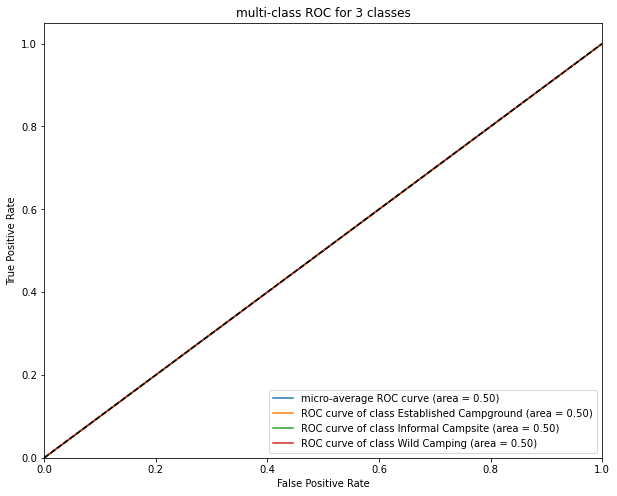

In [19]:
fig, ax = plt.subplots(1, figsize=(10, 8))
multiclass_funcs.multiclass_ROC_plot(class_names, y, predictions, ax, 'multi-class ROC for 3 classes')

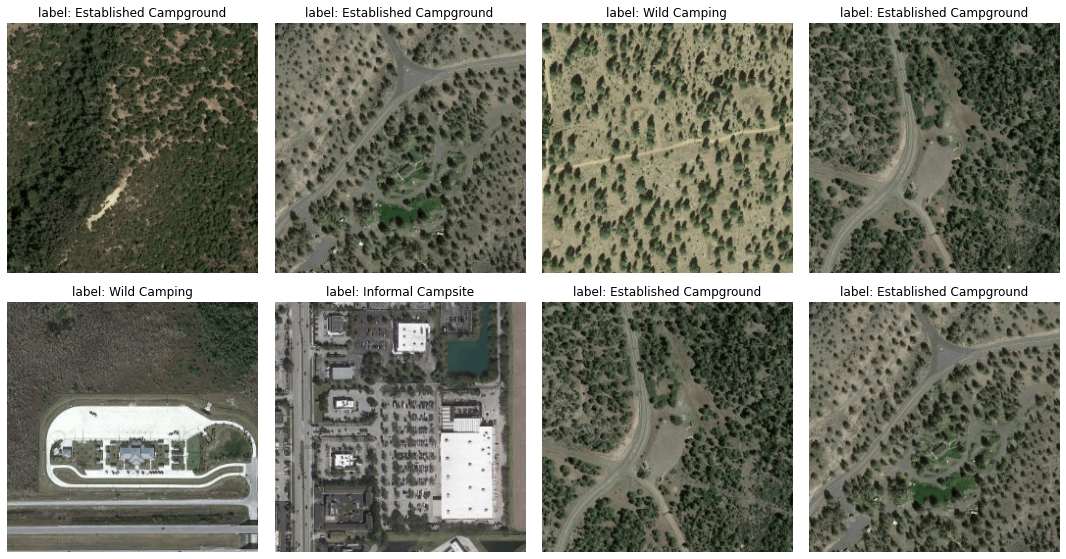

In [20]:
# check model
num_samples = 10
figsize = (15,8)
my_funcs.plot_example_imgs(X_test, class_names, figsize, num_samples);
# plt.savefig('../images/example_imgs.png') 

In [36]:
def compute_confusion_matrix(y_true_class, y_pred_class, class_names):
    '''
    computes confusion matrix and returns as array
    requires sklearn confusion_matrix
    '''
    confmat = confusion_matrix(y_true_class.argmax(axis=1), y_pred_class.argmax(axis=1), normalize='all') #, labels=class_names)
#     confmat = confmat / confmat.sum(0).astype(float)
    return confmat

In [37]:
confmat = compute_confusion_matrix(y, predictions, class_names)
confmat

array([[0.32618235, 0.        , 0.        ],
       [0.23159434, 0.        , 0.        ],
       [0.44222331, 0.        , 0.        ]])

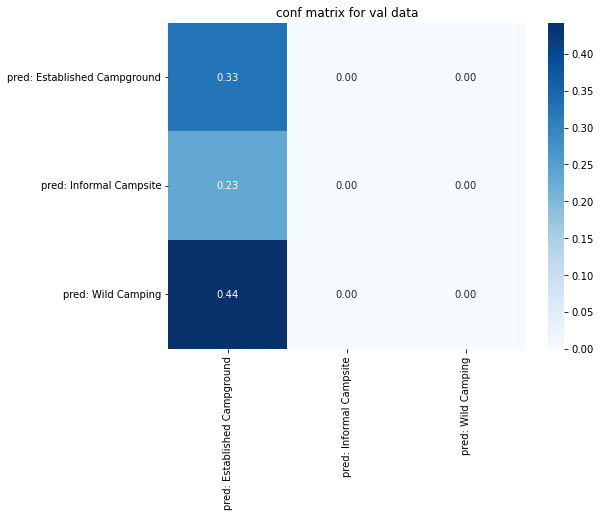

In [40]:
labels = [f'pred: {x}' for x in class_names] 

fig, ax = plt.subplots(1, figsize = (8,6))
ax = my_funcs.plot_conf_matrix(confmat, ax, labels, labels, 'conf matrix for val data')

In [ ]:
def get_imgs_into_df(X_test, y, predictions_binary_vec):
    '''
    accepts tf dataset and y true and binary predictions
    returns a df with predictions, actual, and images in cols
    '''
    # get images into df
    x_test_images = np.concatenate([x for x, y in X_test], axis=0)
    images = pd.Series(list(x_test_images))
    # get predictions into df
    ys = np.column_stack((predictions_binary_vec, y))
    y_predictions_df = pd.DataFrame(ys, columns=['predict', 'actual'])
    # replace labels
    y_predictions_df = y_predictions_df.replace(to_replace=0, value="est_camp")  # ['Established Campground', 'Wild Camping']
    y_predictions_df = y_predictions_df.replace(to_replace=1, value="wild_camp")  # ['Established Campground', 'Wild Camping']
    # add images col
    y_predictions_df['image'] = images
    return y_predictions_df

In [ ]:
y_predictions_df = my_funcs.get_imgs_into_df(X_test, y, y_pred_bin)
wrong_imgs = y_predictions_df[y_predictions_df['predict'] != y_predictions_df['actual']]

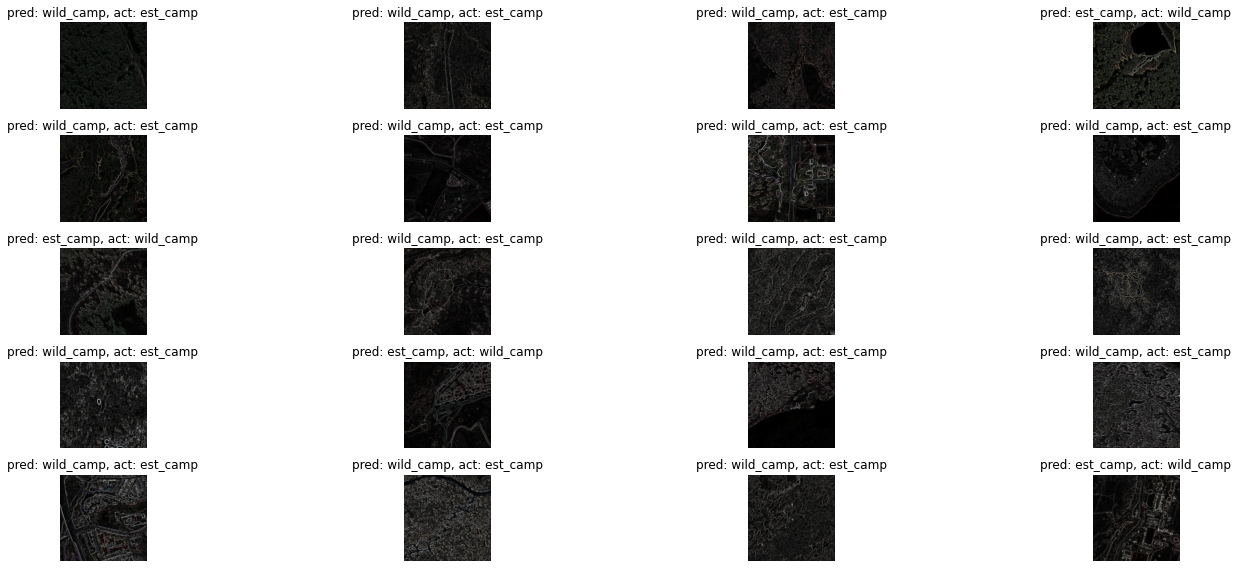

In [ ]:
num_samples = 20
figsize = (20,8)
fig, axs = my_funcs.plot_wrong_imgs(wrong_imgs, figsize, num_samples)